# Hauptvisualisierungen für Streamlit-App

In [7]:
# Imports und Datenvorbereitung
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
import contextily as cx

# Daten laden
dateipfad = './data/zebra_weather_cleaned.csv'
zebra = pd.read_csv(dateipfad)

# Timestamp konvertieren
zebra['timestamp'] = pd.to_datetime(zebra['timestamp'])

print(f"Daten geladen: {len(zebra)} Zeilen")
print(f"Spalten: {list(zebra.columns)}")


Daten geladen: 53776 Zeilen
Spalten: ['event_id', 'visible', 'timestamp', 'location_long', 'location_lat', 'tag_local_identifier', 'individual_local_identifier', 'T2M', 'RH2M', 'WS2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR']


## Visualisierung 1: Geografische Verteilung nach Jahreszeiten


Diese Karte zeigt die Verteilung aller Zebra-Standorte über den gesamten Beobachtungszeitraum (2007-2009), eingefärbt nach Jahreszeit. Die unterschiedlichen Farben verdeutlichen, wie sich die Aufenthaltsorte zwischen Regen- und Trockenzeit unterscheiden und ermöglichen Rückschlüsse auf saisonale Wanderungsmuster der Zebras.


✓ Visualisierung 1 gespeichert: visualizations/visualisierung1_geografische_verteilung.png und .pdf


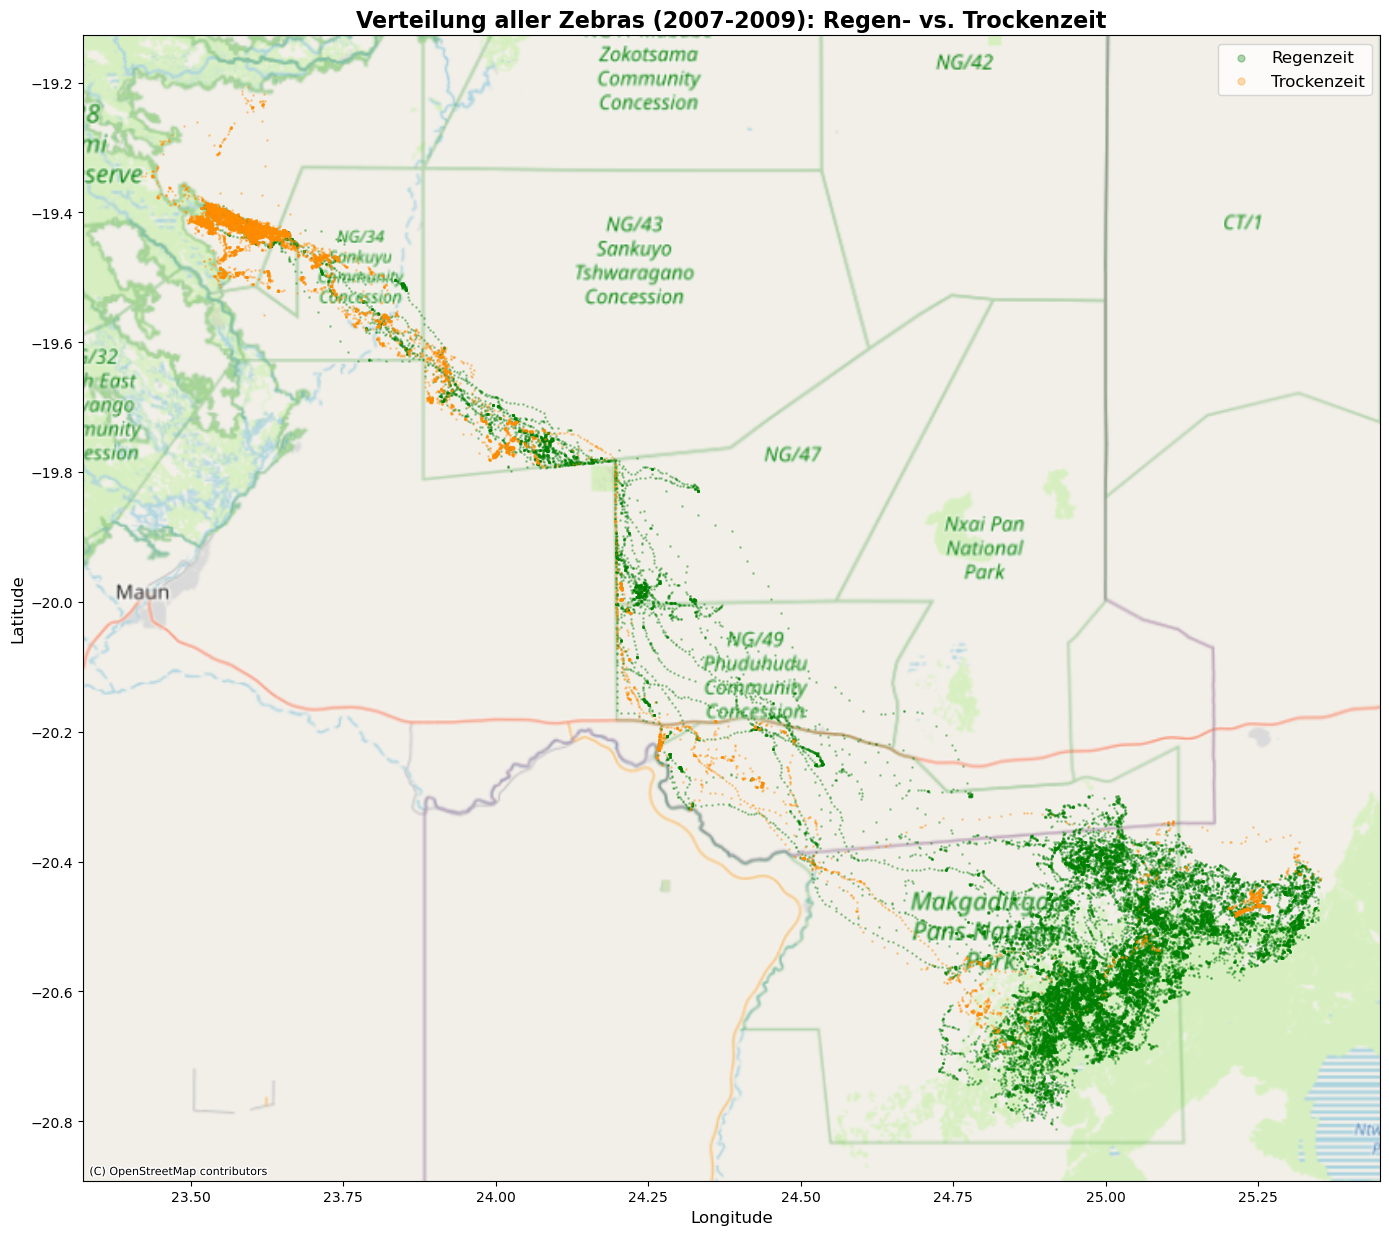

In [8]:
# Visualisierung 1: Geografische Verteilung nach Jahreszeiten

# Jahreszeit-Funktion definieren
def get_season(dt):
    """Bestimmt die Jahreszeit basierend auf dem Monat (für südliches Afrika)"""
    if 5 <= dt.month <= 10:
        return 'Trockenzeit'
    else:
        return 'Regenzeit'

# Saison-Spalte hinzufügen
zebra['season'] = zebra['timestamp'].apply(get_season)

# GeoDataFrame erstellen
geometry = [Point(xy) for xy in zip(zebra['location_long'], zebra['location_lat'])]
gdf_zebra = gpd.GeoDataFrame(zebra, geometry=geometry, crs="EPSG:4326")

# Plot erstellen
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

colors = {'Regenzeit': 'green', 'Trockenzeit': 'darkorange'}

for season, color in colors.items():
    data_subset = gdf_zebra[gdf_zebra['season'] == season]
    data_subset.plot(
        ax=ax,
        marker='o',
        color=color,
        markersize=1,
        alpha=0.3,
        label=season
    )

# Hintergrundkarte hinzufügen
try:
    cx.add_basemap(ax, crs=gdf_zebra.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"Hinweis: Karte konnte nicht geladen werden: {e}")

ax.set_title("Verteilung aller Zebras (2007-2009): Regen- vs. Trockenzeit", fontsize=16, fontweight='bold')
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend(loc='upper right', markerscale=5, fontsize=12)

plt.tight_layout()

# Bild speichern
plt.savefig('visualizations/visualisierung1_geografische_verteilung.png', dpi=300, bbox_inches='tight')
plt.savefig('visualizations/visualisierung1_geografische_verteilung.pdf', bbox_inches='tight')
print("✓ Visualisierung 1 gespeichert: visualizations/visualisierung1_geografische_verteilung.png und .pdf")

plt.show()


## Visualisierung 2: Zeitliche Entwicklung der Bewegungsaktivität

**Auswahl des Zebras:** Für diese detaillierte Analyse haben wir Zebra Z3866 ausgewählt, da es im Jahr 2008 mit über 10.000 Datenpunkten am längsten kontinuierlich getrackt wurde. Dies ermöglicht eine zuverlässige Analyse der saisonalen Bewegungsmuster über ein vollständiges Jahr.


**Erläuterung:** Dieses Zeitreihen-Diagramm zeigt die täglich zurückgelegte Strecke von Zebra Z3866 im Jahr 2008. Wir haben dieses Zebra ausgewählt, weil es das einzige Tier ist, das über einen längeren Zeitraum innerhalb eines Jahres kontinuierlich getrackt wurde - mit über 10.000 Datenpunkten allein im Jahr 2008. Die graue Linie zeigt die täglichen Werte, während die blaue Linie einen 7-Tage-Durchschnitt darstellt, der saisonale Trends besser sichtbar macht. Die farbigen Hintergrundbereiche markieren Regen- und Trockenzeit und zeigen, wie sich die Bewegungsaktivität je nach Jahreszeit verändert.


✓ Visualisierung 2 gespeichert: visualizations/visualisierung2_zeitliche_entwicklung.png und .pdf


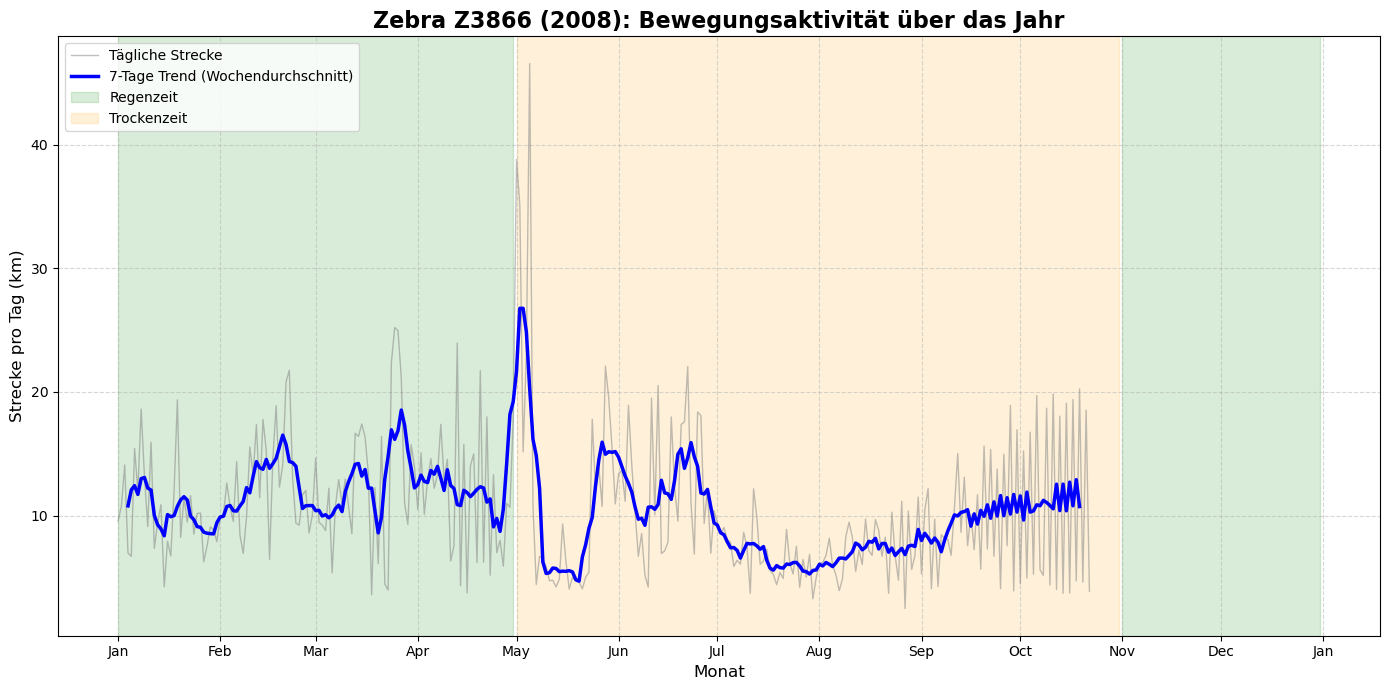

In [9]:
# Visualisierung 2: Zeitliche Entwicklung der Bewegungsaktivität

# Haversine-Funktion für Distanzberechnung
def haversine(lon1, lat1, lon2, lat2):
    """Berechnet die Distanz zwischen zwei GPS-Punkten in Kilometern"""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# Daten für Zebra Z3866 im Jahr 2008 vorbereiten
zebra_z3866_2008 = zebra[zebra['individual_local_identifier'] == 'Z3866'].copy()
zebra_z3866_2008 = zebra_z3866_2008[zebra_z3866_2008['timestamp'].dt.year == 2008]
zebra_z3866_2008 = zebra_z3866_2008.sort_values(by='timestamp')

# Vorherige Koordinaten berechnen
zebra_z3866_2008['prev_lat'] = zebra_z3866_2008['location_lat'].shift(1)
zebra_z3866_2008['prev_long'] = zebra_z3866_2008['location_long'].shift(1)

# Distanz für jeden Schritt berechnen
zebra_z3866_2008['step_km'] = haversine(
    zebra_z3866_2008['location_long'], 
    zebra_z3866_2008['location_lat'], 
    zebra_z3866_2008['prev_long'], 
    zebra_z3866_2008['prev_lat']
)

# Tägliche Strecke summieren
tagesstrecke_2008 = zebra_z3866_2008.groupby(
    zebra_z3866_2008['timestamp'].dt.date
)['step_km'].sum()

# Plot erstellen
plt.figure(figsize=(14, 7))

# Tägliche Werte
plt.plot(tagesstrecke_2008.index, tagesstrecke_2008.values, 
         color='gray', alpha=0.5, linewidth=1, label='Tägliche Strecke')

# 7-Tage Trend
trend = tagesstrecke_2008.rolling(window=7, center=True).mean()
plt.plot(trend.index, trend.values, 
         color='blue', linewidth=2.5, label='7-Tage Trend (Wochendurchschnitt)')

# Jahreszeiten-Hintergrund
plt.axvspan(pd.Timestamp('2008-01-01'), pd.Timestamp('2008-04-30'), 
            color='green', alpha=0.15, label='Regenzeit')
plt.axvspan(pd.Timestamp('2008-05-01'), pd.Timestamp('2008-10-31'), 
            color='orange', alpha=0.15, label='Trockenzeit')
plt.axvspan(pd.Timestamp('2008-11-01'), pd.Timestamp('2008-12-31'), 
            color='green', alpha=0.15)

# Formatierung
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title('Zebra Z3866 (2008): Bewegungsaktivität über das Jahr', fontsize=16, fontweight='bold')
plt.ylabel('Strecke pro Tag (km)', fontsize=12)
plt.xlabel('Monat', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# Bild speichern
plt.savefig('visualizations/visualisierung2_zeitliche_entwicklung.png', dpi=300, bbox_inches='tight')
plt.savefig('visualizations/visualisierung2_zeitliche_entwicklung.pdf', bbox_inches='tight')
print("✓ Visualisierung 2 gespeichert: visualizations/visualisierung2_zeitliche_entwicklung.png und .pdf")

plt.show()


## Visualisierung 3: Statistische Analyse nach Jahreszeiten

**Auswahl des Zebras:** Auch hier verwenden wir Zebra Z3866 aus dem Jahr 2008, da es die umfangreichsten und zuverlässigsten Daten für einen statistischen Vergleich zwischen den Jahreszeiten bietet. Mit über 10.000 Datenpunkten im Jahr 2008 ist es das einzige Zebra, das über einen längeren Zeitraum innerhalb eines Jahres kontinuierlich getrackt wurde.


**Erläuterung:** Dieser Boxplot vergleicht die tägliche Bewegungsaktivität zwischen Regen- und Trockenzeit für Zebra Z3866 im Jahr 2008. Wir haben dieses Zebra für die Analyse ausgewählt, da es über den längsten Zeitraum innerhalb eines Jahres getrackt wurde und somit die zuverlässigsten Daten für einen saisonalen Vergleich liefert. Die Boxen zeigen die Quartile und Medianwerte, während die Whisker die Spannweite der Daten darstellen. Die Visualisierung macht deutlich, ob und wie sich das Bewegungsverhalten zwischen den Jahreszeiten unterscheidet - zum Beispiel, ob Zebras in der Trockenzeit mehr oder weniger zurücklegen als in der Regenzeit.


/var/folders/8v/gy_42drs2hn6m4lfq1g21nr40000gn/T/ipykernel_60944/715831788.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='step_km', data=daily_stats,


✓ Visualisierung 3 gespeichert: visualizations/visualisierung3_statistische_analyse.png und .pdf


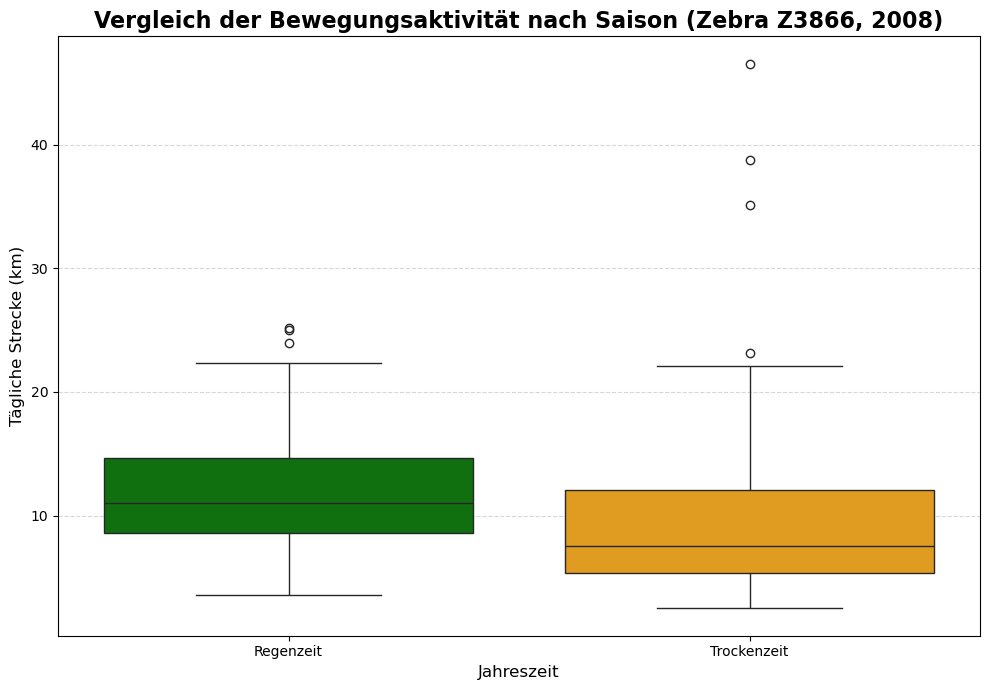

In [10]:
# Visualisierung 3: Statistische Analyse nach Jahreszeiten

# Haversine-Funktion (falls noch nicht definiert)
if 'haversine' not in globals():
    def haversine(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6371 * c
        return km

# Daten für Zebra Z3866 im Jahr 2008 vorbereiten (falls noch nicht vorhanden)
if 'zebra_z3866_2008' not in globals() or 'step_km' not in zebra_z3866_2008.columns:
    zebra_z3866_2008 = zebra[zebra['individual_local_identifier'] == 'Z3866'].copy()
    zebra_z3866_2008 = zebra_z3866_2008[zebra_z3866_2008['timestamp'].dt.year == 2008]
    zebra_z3866_2008 = zebra_z3866_2008.sort_values(by='timestamp')
    zebra_z3866_2008['prev_lat'] = zebra_z3866_2008['location_lat'].shift(1)
    zebra_z3866_2008['prev_long'] = zebra_z3866_2008['location_long'].shift(1)
    zebra_z3866_2008['step_km'] = haversine(
        zebra_z3866_2008['location_long'], 
        zebra_z3866_2008['location_lat'], 
        zebra_z3866_2008['prev_long'], 
        zebra_z3866_2008['prev_lat']
    )

# Saison-Spalte hinzufügen falls nicht vorhanden
if 'season' not in zebra_z3866_2008.columns:
    zebra_z3866_2008['season'] = zebra_z3866_2008['timestamp'].apply(get_season)

# Tägliche Statistiken pro Tag und Saison
daily_stats = zebra_z3866_2008.groupby(zebra_z3866_2008['timestamp'].dt.date).agg({
    'step_km': 'sum',
    'season': 'first'
}).reset_index()

# Boxplot erstellen
plt.figure(figsize=(10, 7))
sns.boxplot(x='season', y='step_km', data=daily_stats, 
            palette={'Regenzeit': 'green', 'Trockenzeit': 'orange'})

plt.title('Vergleich der Bewegungsaktivität nach Saison (Zebra Z3866, 2008)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Tägliche Strecke (km)', fontsize=12)
plt.xlabel('Jahreszeit', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Bild speichern
plt.savefig('visualizations/visualisierung3_statistische_analyse.png', dpi=300, bbox_inches='tight')
plt.savefig('visualizations/visualisierung3_statistische_analyse.pdf', bbox_inches='tight')
print("✓ Visualisierung 3 gespeichert: visualizations/visualisierung3_statistische_analyse.png und .pdf")

plt.show()


## Exportierte Dateien

Die drei Visualisierungen wurden als Bilddateien gespeichert:
- **PNG-Dateien** (hohe Auflösung, 300 DPI) - für Präsentationen und Dokumente
- **PDF-Dateien** (vektorisiert) - für beste Qualität in PDF-Dokumenten

Alle Dateien befinden sich im Ordner `visualizations/`.
